In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [299]:
train=pd.read_csv('https://drive.google.com/uc?export=download&id=1KA7mKUmQv4PrF-qMFrH35LN6q_i56Bf1', 
                  dtype={'StateHoliday':'str'})
store=pd.read_csv('https://drive.google.com/uc?export=download&id=1_o04Vnqzo3v-MTk20MF3OMw2QFz0Fbo0')

In [300]:
train['Date'] = pd.to_datetime(train['Date'])

In [301]:
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.year

In [302]:
train = train.merge(store,on=['Store'])

In [303]:
sales = train[['Store','Date','Sales','Open']]
sales_count = sales.groupby('Store')['Date'].count()
sales=sales[sales['Store'].isin(sales_count[sales_count==sales_count.max()].index)]
sales['Date'] = pd.to_datetime(sales['Date'])

In [304]:
sel_store = sales_count[sales_count==sales_count.max()].index
sel_train = train[train['Store'].isin(sel_store)]
sel_train = sel_train.sort_values(['Store','Date'])

In [305]:
cat = ['DayOfWeek','Month','StoreType','Assortment','StateHoliday']
for c in cat:
    temp=pd.get_dummies(sel_train[c],prefix=c)
    sel_train=pd.concat((sel_train,temp),axis=1)

In [306]:
sel_train=sel_train.drop(cat,axis=1)
sel_train=sel_train[sel_train['Open']==1]

In [307]:
promo = ['Store','Date','Promo','Promo2','Promo2SinceWeek','Promo2SinceYear','Year','PromoInterval']

In [308]:
promotion = train[promo]

In [309]:
promotion = promotion.dropna()

In [310]:
promotion['Promo2SinceWeek']=promotion['Promo2SinceWeek'].astype(int)
promotion['Promo2SinceYear']=promotion['Promo2SinceYear'].astype(int)

In [311]:
promotion['Promo2start']=pd.to_datetime(promotion['Promo2SinceYear'].astype(str), format='%Y') + \
             pd.to_timedelta(promotion['Promo2SinceWeek'].mul(7).astype(str) + ' days')

In [312]:
promotion['Pro']=(promotion['Date']>=promotion['Promo2start']).astype(int)

In [313]:
com = ['Store','Date','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear']

In [314]:
compe = train[com]

In [315]:
compe = compe.dropna()

In [316]:
compe['CompetitionOpenSinceMonth'] = compe['CompetitionOpenSinceMonth'].astype(int)
compe['CompetitionOpenSinceYear'] = compe['CompetitionOpenSinceYear'].astype(int)

In [317]:
df = compe[['CompetitionOpenSinceYear','CompetitionOpenSinceMonth']]
df['int'] = df['CompetitionOpenSinceYear'].astype(str) + df['CompetitionOpenSinceMonth'].astype(str).str.zfill(2)

C:\Users\Seung kyu Hong\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [318]:
compe['Compestart'] = pd.to_datetime(df['int'], format='%Y%m')

In [319]:
compe['Compe'] = (compe['Date']>=compe['Compestart']).astype(int)

In [320]:
sel_train['Pro'] = promotion['Pro']

In [321]:
sel_train['Compe'] = compe['Compe']

In [322]:
def moving_average(data,col,window,lag=0):
    temp1=pd.DataFrame()
    temp2=pd.DataFrame()
    for i in range(1+lag, window+1+lag):
        temp1['%s%d'%(col,i)]=data.groupby('Store')[col].shift(i).values
        temp2['Open%d'%(i)]=data.groupby('Store')['Open'].shift(i).values
    return (np.sum(temp1.values*temp2.values,1)/temp2.sum(1)).values

In [323]:
sel_train['Sales1W']=moving_average(sel_train,'Sales',7,7)
sel_train['Sales2W']=moving_average(sel_train,'Sales',14,7)
sel_train['Sales3W']=moving_average(sel_train,'Sales',21,7)
sel_train['Sales4W']=moving_average(sel_train,'Sales',28,7)
sel_train['Sales1W 4W diff']=sel_train['Sales1W']-sel_train['Sales4W']
sel_train['Sales1W_4W_ratio']=sel_train['Sales1W']/sel_train['Sales4W']

In [324]:
sel_train[['Pro','Compe']] = sel_train[['Pro','Compe']].fillna(0)
sel_train.dropna(inplace=True)

In [333]:
remove_cols = ['Store','Date','Open','Sales','Year','Customers','Promo2','Month_2015','StoreType_b','Assortment_b',
              'CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','StateHoliday_0',
              'Promo2SinceYear','PromoInterval']

In [334]:
trainX = sel_train[sel_train['Date']<=pd.to_datetime('20141231')]
testX = sel_train[sel_train['Date']>pd.to_datetime('20141231')]

In [335]:
trainY = trainX['Sales']
trainX = trainX.drop(remove_cols,axis=1)

testY = testX['Sales']
testX = testX.drop(remove_cols,axis=1)

In [177]:
trainX['CompetitionDistance'] = (trainX['CompetitionDistance'] - trainX['CompetitionDistance'].min())/(trainX['CompetitionDistance'].max() - trainX['CompetitionDistance'].min())

In [90]:
from sklearn.linear_model import LinearRegression , Lasso , Ridge 

In [337]:
reg1 = LinearRegression()
reg1.fit(trainX,trainY)
reg1.score(trainX,trainY)

0.7140644320628372

In [338]:
reg2 = Lasso(alpha=1)
reg2.fit(trainX,trainY)
reg2.score(trainX,trainY)

C:\Users\Seung kyu Hong\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.7137381465298818

In [339]:
reg3 = Ridge(alpha=1)
reg3.fit(trainX,trainY)
reg3.score(trainX,trainY)

0.7140607440069491

In [340]:
alphas = np.logspace(-3,3,30)
result = pd.DataFrame(index=alphas,columns=['Lasso','Ridge'])
for alpha in alphas:
    reg2.alpha = alpha
    reg3.alpha = alpha
    reg2.fit(trainX,trainY)
    result.loc[alpha,'Lasso'] = reg2.score(trainX,trainY)
    reg3.fit(trainX,trainY)
    result.loc[alpha,'Ridge'] = reg3.score(trainX,trainY)

C:\Users\Seung kyu Hong\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Seung kyu Hong\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Seung kyu Hong\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Seung kyu Hong\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did no

C:\Users\Seung kyu Hong\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [341]:
linear_reg = reg1.score(trainX,trainY)

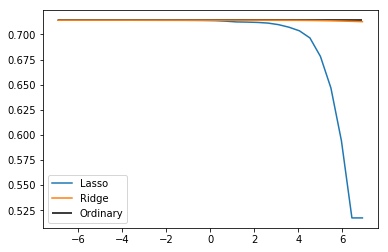

In [343]:
plt.plot(np.log(alphas), result['Lasso'],label='Lasso')
plt.plot(np.log(alphas), result['Ridge'],label='Ridge')
plt.hlines(linear_reg, np.log(alphas[0]),np.log(alphas[-1]),colors='k',
          label='Ordinary')
plt.legend()

In [352]:
from sklearn.model_selection import cross_val_score

In [345]:
a = np.linspace(-6,4,num=10)

Lasso_result = []
Ridge_result = []

for alpha in a:
    reg2.alpha=alpha
    reg3.alpha=alpha
    L = cross_val_score(reg2,trainX,trainY,cv=5)
    R = cross_val_score(reg3,trainX,trainY,cv=5)
    Lasso_result.append(L.mean())
    Ridge_result.append(R.mean())

C:\Users\Seung kyu Hong\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Seung kyu Hong\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Seung kyu Hong\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Seung kyu Hong\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did no

C:\Users\Seung kyu Hong\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Seung kyu Hong\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Seung kyu Hong\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Seung kyu Hong\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did no

In [346]:
Ridge_result

[0.675189823512775,
 0.7098218244899754,
 0.7076199159299171,
 0.7095438933671305,
 0.7093900547665634,
 0.710293344078479,
 0.7103281152869089,
 0.7103356258170617,
 0.7103396394880879,
 0.7103430344412816]

In [348]:
Lasso_result

[0.14112364047482853,
 0.33214102276280566,
 0.4841328250989417,
 0.5973520402392121,
 0.6702673854907445,
 0.7066570562716954,
 0.7102280203876299,
 0.7095470668351039,
 0.7090744790703366,
 0.7087958093690504]

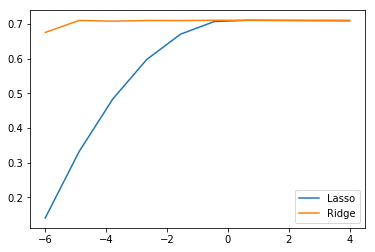

In [351]:
plt.plot(a,Lasso_result,label='Lasso')
plt.plot(a,Ridge_result,label='Ridge')
plt.legend()

In [353]:
reg2 = Lasso(alpha=1)
reg3 = Ridge(alpha=1)

In [354]:
reg2.fit(trainX,trainY)
reg3.fit(trainX,trainY)

C:\Users\Seung kyu Hong\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [355]:
reg2.score(testX,testY)

0.7101964139944779

In [356]:
reg3.score(testX,testY)

0.7044001574777872

In [357]:
reg2.score(trainX,trainY)

0.7137381465298818

In [358]:
reg3.score(trainX,trainY)

0.7140607440069491